<a href="https://colab.research.google.com/github/mzouros/MSc_AI_thesis/blob/main/PSA_Basic_CNN_(DoF).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Imports

import os
import csv

# copy images
import glob
import shutil

import torch
import torchvision
from torchvision import transforms
from torchvision.datasets import ImageFolder

In [ ]:
# Create folders for Train, Validation and Test datasets

# Train, Test & Validation datasets (csvs)
train_data = '/home/mike/Artificial Intelligence MSc/3rd Semester/sniafas/dof-20210913T170626Z-001/dof/dof_train_dataset.csv'
valid_data = '/home/mike/Artificial Intelligence MSc/3rd Semester/sniafas/dof-20210913T170626Z-001/dof/dof_valid_dataset.csv'
test_data = '/home/mike/Artificial Intelligence MSc/3rd Semester/sniafas/dof-20210913T170626Z-001/dof/dof_test_dataset.csv'

# Images' Directory
images = '/home/mike/Artificial Intelligence MSc/3rd Semester/sniafas/unsplash-square/'

# New directories for Train, Test & Validation images
train_deep = '/home/mike/Artificial Intelligence MSc/3rd Semester/sniafas/train/deep'
train_shallow = '/home/mike/Artificial Intelligence MSc/3rd Semester/sniafas/train/shallow'
valid_deep = '/home/mike/Artificial Intelligence MSc/3rd Semester/sniafas/validation/deep'
valid_shallow = '/home/mike/Artificial Intelligence MSc/3rd Semester/sniafas/validation/shallow'
test_deep = '/home/mike/Artificial Intelligence MSc/3rd Semester/sniafas/test/deep'
test_shallow = '/home/mike/Artificial Intelligence MSc/3rd Semester/sniafas/test/shallow'
 

# Train Dataset (560)
with open(train_data) as csv_file:
    print("Train Data:")
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    for row in csv_reader:
        if line_count == 0:
            line_count += 1
        else:
#             print(f'{row[0]} has DoF label {row[1]}')
            for image in glob.iglob(os.path.join(images, "*.jpg")):
                if os.path.basename(os.path.normpath(image)) == row[0]:
                    if (row[1] == '0'): # shallow
                        shutil.copy((image), train_shallow)
                    else: # deep
                        shutil.copy((image), train_deep)
            line_count += 1
    print(f'Total {line_count-1} training data')

# Validation Dataset (140)
with open(valid_data) as csv_file:
    print("Validation Data:")
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    for row in csv_reader:
        if line_count == 0:
            line_count += 1
        else:
#             print(f'{row[0]} has DoF label {row[1]}')
            for image in glob.iglob(os.path.join(images, "*.jpg")):
                if os.path.basename(os.path.normpath(image)) == row[0]:
                    if (row[1] == '0'): # shallow
                        shutil.copy((image), valid_shallow)
                    else: # deep
                        shutil.copy((image), valid_deep)
            line_count += 1
    print(f'Total of {line_count-1} validation data')

# Test Dataset (500)
with open(test_data) as csv_file:
    print("Test Data:")
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    for row in csv_reader:
        if line_count == 0:
            line_count += 1
        else:
#             print(f'{row[0]} has DoF label {row[1]}')
            for image in glob.iglob(os.path.join(images, "*.jpg")):
                if os.path.basename(os.path.normpath(image)) == row[0]:
                    if (row[1] == '0'): # shallow
                        shutil.copy((image), test_shallow)
                    else: # deep
                        shutil.copy((image), test_deep)
            line_count += 1
    print(f'Total of {line_count-1} test data')

In [2]:
# Train & Test folders
train_images = '/home/mike/Artificial Intelligence MSc/3rd Semester/sniafas/train/'
test_images = '/home/mike/Artificial Intelligence MSc/3rd Semester/sniafas/test/'

# Load, resize and create tensors
train_dataset = ImageFolder(train_images,transform = transforms.Compose([
    transforms.Resize((150,150)),transforms.ToTensor()
]))
test_dataset = ImageFolder(test_images,transforms.Compose([
    transforms.Resize((150,150)),transforms.ToTensor()
]))

img, label = train_dataset[0]
print(f"Shape: {img.shape}\nLabel: {label}")
print("Classes :", train_dataset.classes)

Shape: torch.Size([3, 150, 150])
Label: 0
Classes : ['deep', 'shallow']


In [3]:
# Split Training & Validation Data

from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split

batch_size = 64
val_size = 140
train_size = len(train_dataset) - val_size 

train_data,val_data = random_split(train_dataset,[train_size,val_size])
print(f"Length of Train Data : {len(train_data)}")
print(f"Length of Validation Data : {len(val_data)}")

#load the train and validation into batches.
train_dl = DataLoader(train_data, batch_size, shuffle = True, num_workers = 4, pin_memory = True)
val_dl = DataLoader(val_data, batch_size*2, num_workers = 4, pin_memory = True)

Length of Train Data : 560
Length of Validation Data : 140


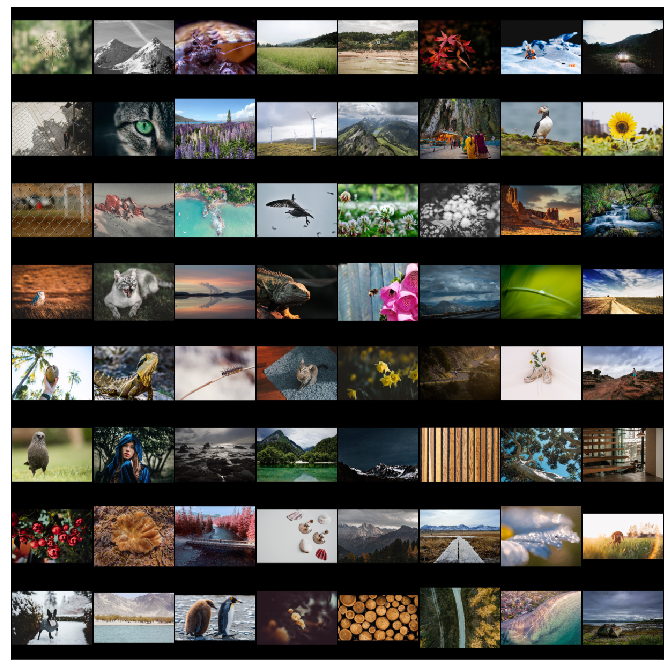

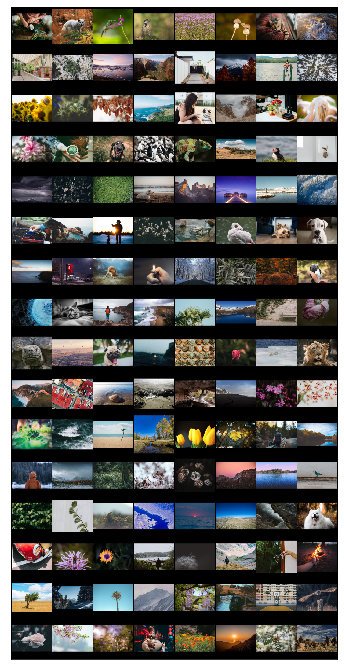

In [5]:
# Visualize data as a grid

from torchvision.utils import make_grid
import matplotlib.pyplot as plt

def show_batch(dl):
    """Plot images grid of single batch"""
    for images, labels in dl:
        fig,ax = plt.subplots(figsize = (16,12))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images,nrow=8).permute(1,2,0))
        break
        
show_batch(train_dl)
show_batch(val_dl)

In [6]:
# Functions

import torch.nn as nn
import torch.nn.functional as F

# Basic training/validation structure
class ImageClassificationBase(nn.Module):
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))
        

# Basic 3-layer CNN model
class NaturalSceneClassification(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            
            nn.Conv2d(3, 32, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.Conv2d(32,64, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
        
            nn.Conv2d(64, 128, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(128 ,128, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            
            nn.Conv2d(128, 256, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(256,256, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            
            nn.Flatten(),
            nn.Linear(82944,1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512,6)
        )
    
    def forward(self, xb):
        return self.network(xb)
    
    
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

  
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

  
def fit(epochs, lr, model, train_loader, val_loader, opt_func = torch.optim.SGD):
    
    history = []
    optimizer = opt_func(model.parameters(),lr)
    for epoch in range(epochs):
        
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    
    return history

In [7]:
# Train CNN

model = NaturalSceneClassification()
num_epochs = 15
opt_func = torch.optim.Adam
lr = 0.001 #fitting the model on training data and record the result after each epoch
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

Epoch [0], train_loss: 1.5314, val_loss: 0.7570, val_acc: 0.5755
Epoch [1], train_loss: 0.7276, val_loss: 0.6885, val_acc: 0.5755
Epoch [2], train_loss: 0.6975, val_loss: 0.6822, val_acc: 0.5755
Epoch [3], train_loss: 0.7074, val_loss: 0.6914, val_acc: 0.5755
Epoch [4], train_loss: 0.7039, val_loss: 0.7177, val_acc: 0.4245
Epoch [5], train_loss: 0.7014, val_loss: 0.6988, val_acc: 0.4245
Epoch [6], train_loss: 0.7024, val_loss: 0.6871, val_acc: 0.5755
Epoch [7], train_loss: 0.7167, val_loss: 0.6872, val_acc: 0.5755
Epoch [8], train_loss: 0.7031, val_loss: 0.6821, val_acc: 0.5755
Epoch [9], train_loss: 0.6977, val_loss: 0.7169, val_acc: 0.4245
Epoch [10], train_loss: 0.6949, val_loss: 0.6821, val_acc: 0.5755
Epoch [11], train_loss: 0.6977, val_loss: 0.7112, val_acc: 0.4245
Epoch [12], train_loss: 0.6959, val_loss: 0.6833, val_acc: 0.5755
Epoch [13], train_loss: 0.7016, val_loss: 0.7215, val_acc: 0.4245
Epoch [14], train_loss: 0.7001, val_loss: 0.6829, val_acc: 0.5755


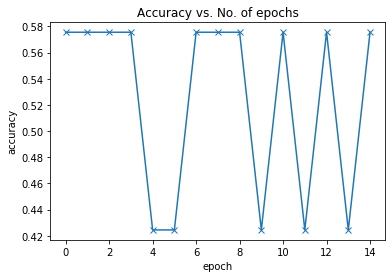

In [10]:
# Plots

# Accuracy
def plot_accuracies(history):
    """ Plot the history of accuracies"""
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');
    
# Loss
def plot_losses(history):
    """ Plot the losses in each epoch"""
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

plot_accuracies(history)
plot_losses(history)

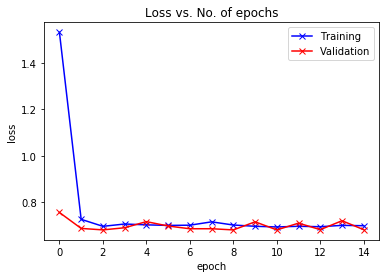

In [11]:
plot_losses(history)